<a href="https://colab.research.google.com/github/JohnnyPeng123/NLP-USYD/blob/master/JPEN6856_COMP5046_Ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5046 Assignment 1
*To skip the model training parts and save your time and, please only run cells with "Run This Cell" sign. Please do not run cells without this sign, unless you would like to play with codes*

# 1 - Data Preprocessing

## 1.1. Download Dataset

In [2]:
####################################
###### Run This Cell #########
####################################

# Code to download file into Colaboratory:
!pip install -U -q PyDrive
!pip install unidecode
!pip3 install lemminflect
!pip install spacy
import unidecode
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

import pandas as pd
df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist()
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

reviews_train_original = df_train['review'].tolist()
reviews_test_original = df_test['review'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

     |████████████████████████████████| 245kB 2.7MB/s 
     |████████████████████████████████| 778kB 2.7MB/s 
Training set number: 25000
Testing set number: 25000


## 1.2. Preprocess data

Here are the processing steps that we'll take to clean up our data:
>
1. Case folding - Convert all the characters to lower-case.
  * Reason: Even though Upper-case and lower-case might change the meaning of a sentence in some situation, but the overall sentiment of the reviews are unlikely to be impacted by this, and by doing this we can reduce the sparseness of our data.

  * Codes: words.lower()

1. Expand Contractions.
  * Reason: Reduce sparseness of our data. It is not ideal to treat words like "you're" as a separate single word in our vocab.

  * Codes: expand_contractions()  

2. Get rid of periods and extraneous punctuation.
  * Reason: Punctuations cannot indicate whether a review is positive or negative, rather, it indicates the magnitudes of the sentiment. Thus, it's not useful for our purpose given we are not trying to predictive the magnitudes, hence we will get rid of them.  

  * Codes: remove_punctuation_re()

3. Tokenisation - Convert reviews to words level.
  * Reason: We will need to train and use embeddings at the word level, also word-level data transformation will happen in the next step.
  
  * Codes: word_tokenize()
4. Normalization - Remove accents for all the words in our texts.
  * Reason: Accents do not contribute to the sentiment of a movie review, and by doing this we can reduce the sparseness of our data.

  * Codes: unidecode.unidecode()
5. Remove misspell words and made-up words
  * Reason: These words are likely to be very infrequent in our data, and hence it is unlikely to get a meaningful embedding out of it, might as well remove them to reduce dataset size and speed up the training process.

  * Codes: words in english_words

6. Remove Numbers.
  * Reason: Like punctuations, numbers carry quantitative meanings, which contribute little to predicting the sentiment of the reviews. 
  
  * Codes: word.isalpha()

6. Remove words with single characters.
  * Reason: After the punctuations got removed from our text, some single characters will not make sense anymore. For example, "Jack's apple" will become "jack s apple", even though that s can still provide some dependency information, however, I do not think that can change the sentiment of the review. Note that there are three exceptions, "a","i" will be kept, and "u" will be converted to "you". 
  
  * Codes: word not in single_words

7. POS tagging.
  * Reason: since we will be performing lemmatization in the next step, we are required to perform POS tagging beforehand to do lemmatization properly.

  * Codes: nlp(' '.join(review_tmp))  

8. Lemmatization
  * Reason: Lemmatiztion helps to normalize our words by grouping the same words with different forms together, and hence reduce sparseness in our data, which would be beneficial for both training embeddings and sentiment analysis.

  * Codes: w._.lemma()

Note that these steps have to happen in order, otherwise the final results might be different. For example, we will be making mistake if we remove punctuations before expanding contractions, that is because after we remove punctuations "you're" will become "youre", which is not in our contractions dictionary.  

Please also note that I am not happy with the accuracy of the lemmatization package from nltk, so I have installed some external libraries to perform the lemmatization task instead. These libraries include: spacy, lemminflect 

The english_words dictionary used in this code are from the Github below:
https://github.com/dwyl/english-words

I find the English dictionary from nltk very out-of-date. For example, the English dictionary from nltk does not even have the word "enjoyed" in it. so I used the one above instead.

In [0]:
####################################
######## Run This Cell #########
####################################
id = '1o2k7nw9oYWMAsgKEFBCAeaMIWlCqBB8m'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('words_alpha.txt')

def load_words():
    with open('words_alpha.txt') as word_file:
        valid_words = set(word_file.read().split())

    return valid_words

english_words = load_words()

import re
contractions_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    s = re.sub("\'","'",s)
    return contractions_re.sub(replace, s)

def remove_punctuation_re(x):
    x = re.sub('<br />',' ',x)
    x = re.sub(r'[^\w\s]',' ',x)
    x = re.sub(' u ',' you',x)
    return x

def remove_punctuation_re2(x):
    x = re.sub(r'[^\w\s]','',x)
    return x

single_words = ['b', 'c', 'd', 'e', 'f', 'g',
         'h', 'j', 'k', 'l', 'm', 'n',
         'o', 'p', 'q', 'r', 's', 't', 'u',
         'v', 'w', 'x', 'y', 'z']

In [0]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import lemminflect
import spacy
nlp = spacy.load('en_core_web_sm')

def preprocess(data):
  for i in range(len(data)):
    review_tmp = []
    review_final = []
    data_temp = remove_punctuation_re(expand_contractions(data[i].lower()))
    for word in word_tokenize(data_temp):
      word_temp = unidecode.unidecode(word)
      if word_temp.isalpha() and word_temp in english_words and word_temp not in single_words:
        review_tmp.append(word_temp)
    review_tmp1 = nlp(' '.join(review_tmp))
    for w in review_tmp1:
      review_final.append(remove_punctuation_re2(str(w._.lemma())))
    data[i] = ' '.join(review_final)
  return data

reviews_train = preprocess(reviews_train)
reviews_test = preprocess(reviews_test)

# create a list that contains the all the words from both training and test dataset
reviews = reviews_test + reviews_train
all_text = ' '.join([w for w in reviews])
all_words = all_text.split()

In [0]:
# Save the pre-processed data, preventing from re-running the pre-process steps.
with open("/content/drive/My Drive/reviews_test.txt", "w") as f:
    for s in reviews_test:
        f.write(str(s) +"\n")

with open("/content/drive/My Drive/reviews_train.txt", "w") as f:
    for s in reviews_train:
        f.write(str(s) +"\n")

with open("/content/drive/My Drive/all_words.txt", "w") as f:
    for s in all_words:
        f.write(str(s) +"\n")

In [0]:
reviews_test_original = reviews_test
reviews_train_original = reviews_train
all_words_original = all_words

In [0]:
####################################
######## Run This Cell #########
####################################

# Load the pre-processed data.
reviews_test = []
reviews_train = []
all_words = []

id = '1-8-7FqqcfhssoBtygvUk_JLUEDX_OcEn'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('reviews_test.txt')

id = '1-8HCFH6YMo9ODwcZid5W2AauBFXjCPyI'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('reviews_train.txt')

id = '1-8TuOnFLSxdpQv7qG8lyQORAJLQuLXDG'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('all_words.txt')

with open("reviews_test.txt", "r") as f:
  for line in f:
    reviews_test.append(line.strip())

with open("reviews_train.txt", "r") as f:
  for line in f:
    reviews_train.append(line.strip())

with open("all_words.txt", "r") as f:
  for line in f:
    all_words.append(line.strip())

reviews = reviews_train + reviews_test

In [0]:
####################################
######## Run This Cell #########
####################################

from collections import Counter
import numpy as np 

## Build a dictionary that maps words to integers
counts = Counter(all_words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab)}

## use the dict to tokenize each words in reviews.split()
## store the tokenized reviews in reviews_ints_train & reviews_ints_test
reviews_ints_train = []
for review in reviews_train:
    reviews_ints_train.append([vocab_to_int[word] for word in review.split()])

reviews_ints_test = []
for review in reviews_test:
    reviews_ints_test.append([vocab_to_int[word] for word in review.split()])  

In [5]:
print(len(all_words))
print(len(vocab))

11385282
43054


In [98]:
# Manual spot check
print(reviews_test_original[7])
print(reviews_test[7])
print(sentiments_test_int[7])

I think the film makes a subtile reference to rouge of Kieslowski, as the whole atmosphere gives me a feeling of red. It seems to be that a lot of the backgrounds contain red, think of the tea-room f.e. I also think this is one of the greatest movies of the last years.
i think the film make a subtile reference to rouge of as the whole atmosphere give me a feeling of red it seem to be that a lot of the background contain red think of the tea room i also think this be one of the great movie of the last year
1


In [0]:
####################################
######## Run This Cell #########
####################################

# Define efficient one-encoding function for Tensors
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

# 2 - Model Implementation

## 2.1. Word Embeddings

We will be implementing the Skip-Gram model, which is a neural network model which use the target words to predicts its context words. All the words in our text will be the target words, and the words around each target words will be the context words.

Once the model is trained, the hidden layers will be the word embeddings that we can use to train character embedding and perform sentiment analysis. 

The reasons that we chose Skip-Gram over CBOW is shown below:
>
* Skip-Gram model is better for infrequent words, although it is slower to train compared to the CBOW approach.
  * Skip-Gram is a one-to-one model, which means that a target word is responsible to predict/explain one context word, that means when the loss was generated from the backprop, one single target word's embedding will absorb all the loss and update correspondingly. 
  
    Whereas CBOW uses multiple context words to predict the target words, so each context words will be responsible to explain parts of the target word, which also means that each of the word embeddings will not get updated as much (as in the Skip-Gram model) during the training process.  

    For frequent words, both CBOW and Skip-Gram should be fine as they appear a lot in our training dataset, and hence their word embedding got update more often.   
    
    However, for infrequent words, their embeddings are more likely to be under-trained in the CBOW model as the update magnitude is relatively smaller in CBOW.  

    The original word2vec paper from Google also endorsed this idea:
  https://code.google.com/archive/p/word2vec/
  
    (Under the "Performance" sub-title, search for "performance" to see it)


### 2.1.1. Data Preprocessing for Word Embeddings

Following are the data preprocessing done for training the word embeddings:

>
1. Sub-sampling frequent words
  * This is a common technique used in NLP to create a more balanced training dataset, where we discard words in our training dataset based on their frequency in our data. More frequent words are more likely to get discarded. That way our training process will not be dominant by frequent but meanless stop words such as "the", "is", "are".    

     One benefit of sub-sample frequent words is that, it does not remove all the stop words, rather, it merely reduces the frequency of the stop words in our training dataset. This is a desired feature as some of the stop words can change the sentiment of the sentence. Take "This movie is not good." as an example, if we remove all the stop words, the sentence will become "movie good.", which has a sentiment that is opposite to the original sentence.

     Other benefits of sub-sample frequent words including improving both accuracy and speed for large data sets, which endorsed by the original Word2Vec paper by Google:

     https://code.google.com/archive/p/word2vec/

    (Under the "Performance" sub-title, search for "performance" to see it)


2. Break the reviews into target words and context words.
  * Detailed process is shown in the code, which creates the training dataset for the Skip-Gram model.  

3. One-hot Encoding.
  * One-hot encoding is applied to convert the target words into a spare vector that feeds into the Skip-Gram model. Note that, due to the RAM limit on Colab, this is done by batches when training the Skip-Gram model.
   
Note that I did not implement the "Negative Sampling" or "Hierarchical Softmax" techniques due to time constraints on this assignment, if I have more time I would definitely give them a go.

In [0]:
import random
random.seed(88)

reviews_subsample = []
for review in reviews:
  review_temp = []
  for word in review.split():
    frac = counts[word]/len(all_words)
    prob = (np.sqrt(frac/0.001) + 1) * (0.001/frac)
    
    if np.random.random() < prob:
        review_temp.append(word)
  
  reviews_subsample.append(' '.join([w for w in review_temp]))  

In [0]:
# Making window size 5 skip-gram
skip_grams_target = []
skip_grams_context = []
vocab_size = len(vocab_to_int)
window_size = 5

for j in range(len(reviews_subsample)):
  words = word_tokenize(reviews_subsample[j])
  for i in range(len(words)):
    target = vocab_to_int[words[i]]
    context_temp = []
    
    if i >= window_size and i <= (len(words) - window_size):   
      for word in words[i - window_size:i]:
          context_temp.append(vocab_to_int[word])
      for word in words[i+1:i + window_size + 1]:
          context_temp.append(vocab_to_int[word])
    
    if i < window_size:
      if i > 0:
       for word in words[0:i]:
           context_temp.append(vocab_to_int[word])
      for word in words[i+1:i + window_size + 1]:
          context_temp.append(vocab_to_int[word])

    if i > (len(words) - window_size):
      for word in words[i - window_size:i]:
          context_temp.append(vocab_to_int[word])
      if i != len(words)-1:
       for word in words[i+1:len(words)]:
           context_temp.append(vocab_to_int[word])

    context = context_temp

    # skipgrams - (target, context[0]), (target, context[1])..
    for w in context:
          skip_grams_target.append(target)
          skip_grams_context.append(w)    

print(len(skip_grams_target))
print(len(skip_grams_context))

78945061
78945061


In [0]:
# Create Batches
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 1000

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.array(skip_grams_target)), torch.from_numpy(np.array(skip_grams_context)))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers = 4, pin_memory=True, drop_last=True)

### 2.1.2. Build Word Embeddings Model

Here are justifications for the hyperparameter choices:
>
1. Number of Epoch = 1
  * Reason: Our training dataset is too big, even 1 epoch will takes at least a few hours to train (also depends on other hyperparameters). Given the Colab's runtime will be reset after every 12 hours or when the laptop is not active, if I set the number epoch to be greater than 1, it's very likely the Colab runtime will be reset before the training process finish. At that point, I will have to re-train everything again. So even though I believe more epoch here might gives a more accurate results, but I still set it to be 1 here. 

    In addition, the loss is pretty much converged at end of the first epoch, so marginal benefit from additional epoch would be minimal.   
2. Batch Size = 1000
  * Reason: Given the large dataset that we are working with, I tried to set the batch size as high as possible to speed up the training process. Due to the RAM constraints on the CPU in Colab, 1000 batch size is roughtly the highest batch size I can set.  

3. Window Size = 5
  * Reason: Even though the orignal paper word2vec paper from google recommended window size of 10 for skip-gram model, however it will makes the training dataset significantly bigger than window size of 5. Due to the time constraints on this assignmetn, and the runtime & RAM limits on Colab, I decided to go with the window size of 5.  
  
4. Probability threshold for the sub-sampling frequent words = 1e-3
  * Reason: The original word2vec paper by Google recommended 1e-3 to 1e-5 for this hyperparameter. After trying out both 1e-3 and 1e-5, training with 1e-3 lead to a much lower losses compare to training with 1e-5. That might because the probability threshold 1e-5 is too low, which causing too many words being  removed, and thus destoryed the relevance between target words and context words.    
  
5. Learning Rate = 0.0001
  * Reason: After multiple trial and errors, this learning rate = 0.0001 seems to give the lowest and the most stable losses.

6. Embedding Size = 100
  * Reason: After trying out different embedding sizes (50, 100, 300), I found that there is no signifcant difference in losses between embedding size of 100 and 300, whlist training with embedding size = 100 is signficantly faster. However, dropping the embedding size from 100 to 50 signifcantly increased the losses, which is not desired. Thus, the embedding size was set at 100.  

Note that, some of the reasoning above are based on the training losses and trial & errors. Even though I forgot to keep a track of all the results (otherwise I could have visualize them here), I hope explain them as text would makes sense to you. 

In addition, even though I understand that the losses from training the word embedding may not indicates its effectiveness in the end-application (which is sentiment analysis in this case). However, due to the time constraints, I am unable to run the end-to-end process (training word embedding + training character embedding + sentiment analysis) multiple times to find the best hyperparameter for training the word embedding.   

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyperparameters
learning_rate = 0.0001
embedding_size = 100
voc_size = len(vocab_to_int)

class SkipGram(nn.Module):
    def __init__(self):
        super(SkipGram, self).__init__()
        self.linear1 = nn.Linear(voc_size, embedding_size,bias=False)
        self.linear2 = nn.Linear(embedding_size, voc_size,bias=False)

    def forward(self, x):
        hidden = self.linear1(x)
        out = self.linear2(hidden)
        return out

skip_gram_model = SkipGram().to(device)
criterion = nn.CrossEntropyLoss() #please note we are using "CrossEntropyLoss" here
optimiser = optim.Adam(skip_gram_model.parameters(), lr=learning_rate)

### 2.1.3. Train Word Embeddings Model

In [0]:
data_len = len(skip_grams_target)
epoch_count = 0
        
for epoch in range(1):
     epoch_count += 1  
     for batch_idx, (inputs, labels) in enumerate(train_loader):
       inputs_torch = to_one_hot(inputs,len(vocab_to_int)).to(device)
       labels_torch = labels.to(device)
       
       skip_gram_model.train()
       # zero the parameter gradients
       optimiser.zero_grad()

       # forward + backward + optimize
       outputs = skip_gram_model(inputs_torch)
       loss = criterion(outputs, labels_torch) # We don't need to calcualte logsoftmax here
       loss.backward()
       optimiser.step()
       if batch_idx == 0:
         print('epoch: %d, loss: %.4f' %(0, loss))
       if batch_idx % 1000 == 0:
        print(' Iteration: %d, loss: %.4f' %(batch_idx, loss))
     print('epoch: %d, loss: %.4f' %(epoch_count, loss))

epoch: 0, loss: 10.6703
 Iteration: 0, loss: 10.6703
 Iteration: 1000, loss: 9.5605
 Iteration: 2000, loss: 8.1712
 Iteration: 3000, loss: 7.8316
 Iteration: 4000, loss: 7.6837
 Iteration: 5000, loss: 7.7350
 Iteration: 6000, loss: 7.6231
 Iteration: 7000, loss: 7.4257
 Iteration: 8000, loss: 7.5012
 Iteration: 9000, loss: 7.6593
 Iteration: 10000, loss: 7.5217
 Iteration: 11000, loss: 7.6611
 Iteration: 12000, loss: 7.4782
 Iteration: 13000, loss: 7.5563
 Iteration: 14000, loss: 7.4403
 Iteration: 15000, loss: 7.4649
 Iteration: 16000, loss: 7.4638
 Iteration: 17000, loss: 7.4529
 Iteration: 18000, loss: 7.6235
 Iteration: 19000, loss: 7.5052
 Iteration: 20000, loss: 7.3947
 Iteration: 21000, loss: 7.4397
 Iteration: 22000, loss: 7.5182
 Iteration: 23000, loss: 7.4472
 Iteration: 24000, loss: 7.3619
 Iteration: 25000, loss: 7.4264
 Iteration: 26000, loss: 7.4095
 Iteration: 27000, loss: 7.4824
 Iteration: 28000, loss: 7.4344
 Iteration: 29000, loss: 7.2796
 Iteration: 30000, loss: 7.5

### 2.1.4. Save Word Embeddings Model

In [0]:
torch.save(skip_gram_model, '/content/drive/My Drive/word_embedding.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SkipGram. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.1.5. Load Word Embeddings Model

In [0]:
####################################
######## Run This Cell #########
####################################

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 

class SkipGram(nn.Module):
    def __init__(self):
        super(SkipGram, self).__init__()
        self.linear1 = nn.Linear(voc_size, embedding_size,bias=False)
        self.linear2 = nn.Linear(embedding_size, voc_size,bias=False)

    def forward(self, x):
        hidden = self.linear1(x)
        out = self.linear2(hidden)
        return out

id = '1Pv9s7gmJxllyF6zN7aX8il8k3JmQjRWA'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('word_embedding.pt')

skip_gram_model_load = torch.load('word_embedding.pt')
weight1 = skip_gram_model_load.linear1.weight.data
trained_embeddings = weight1.detach().cpu().T.numpy()

## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

most of the pre-process works have already been done in the previous sessions.
So the only pre-processing work that we will be doing for training our character embedding is padding.

As we can see, the longest words in our dictonary has 20 characters, hence we will be pad all the inputs to character embedding to have a length of 20.

In [8]:
####################################
######## Run This Cell #########
####################################

#Assume that we have the following character instances
char_arr = ['a', 'b', 'c', 'd', 'e', 'f', 'g',
            'h', 'i', 'j', 'k', 'l', 'm', 'n',

            'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z','pad']

# one-hot encoding and decoding 
# {'a': 0, 'b': 1, 'c': 2, ..., 'j': 9, 'k', 10, ...}
num_dic = {n: i for i, n in enumerate(char_arr)}
dic_len = len(num_dic)

word_len = {}

list_words = list(vocab_to_int.keys())
for i in range(len(list_words)):
  char_tmp = [num_dic[n] for n in list_words[i]]
  word_len[list_words[i]] = len(char_tmp) 
word_len = {k: v for k, v in sorted(word_len.items(), key=lambda item: item[1],reverse=True)}
max_word_len = list(word_len.items())[0][1]
print(max_word_len)

20


In [8]:
# Make a batch to have sequence data for input and ouput
def make_batch(seq_data):
    input_batch = []
    target_batch = []
    
    for seq in seq_data:
        input_data = list([num_dic[n] for n in seq])
        for i in range(max_word_len - len(input_data)):
          input_data.append(26) 
        target = trained_embeddings[vocab_to_int[seq]]
        
        input_batch.append(input_data)      
        target_batch.append(target)

    return input_batch, target_batch

# Preparing input
input_batch, target_batch = make_batch(all_words)
# Convert input into tensors and move them to GPU by uting tensor.to(device)
print(len(input_batch))

11385282


### 2.2.2. Build Character Embeddings Model

Here are justifications for the hyperparameter choices:
>
1. Number of Epoch = 30
  * Reason: Based on trial and errors, the losses will be converged after 30 epoch.   

2. Batch Size = 1000
  * Reason: Given the large dataset that we are working with, I tried to set the batch size as high as possible to speed up the training process. Due to the RAM constraints on the CPU in Colab, 1000 batch size is roughtly the highest batch size I can set.    
  
3. Learning Rate = 0.0001
  * Reason: After multiple trial and errors, this learning rate gives the lowest and the most stable losses.

6. Embedding Size = 100
  * Reason: After trying out different embedding sizes, I found that there is no signifcant difference in losses between embedding size of 100 and 300, whlist training with embedding size = 100 is signficantly faster. However, dropping the embedding size from 100 to 50 signifcantly increased the losses, which is not desired. Thus, the embedding size was set at 100.  

Note that, even though I understand that the losses from training the word embedding may not indicates its effectiveness in the end-application (which is sentiment analysis in this case). However, due to the time constraints, I am unable to run the end-to-end process (training word embedding + training character embedding + sentiment analysis) multiple times to find the best hyperparameter for training the character embedding.   

In [0]:
### Setting hyperparameters
learning_rate = 0.0001
n_hidden = 128
total_epoch = 50
batch_size = 1000
n_layers = 2
# number of inputs (dimension of input vector) = 27
n_input = dic_len
word_embedding_size = trained_embeddings.shape[1]

In [0]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
device = 'cuda'
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden,num_layers = n_layers, batch_first =True,bidirectional=True)
        self.linear = nn.Linear(n_hidden * 2,word_embedding_size)

    def forward(self, x):
        x,(h_n,_) = self.lstm(x)
        #concat the last hidden state from two direction
        hidden_out =torch.cat((h_n.view(n_layers,2,-1,n_hidden)[1,0,:,:],h_n.view(n_layers,2,-1,n_hidden)[1,1,:,:]),1)
        x = self.linear(hidden_out)
        return x, hidden_out

# Move the model to GPU
net = Net().to(device)
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

### 2.1.4. Train Character Embeddings Model

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_char_data = TensorDataset(torch.from_numpy(np.array(input_batch)), torch.from_numpy(np.array(target_batch)))
train_char_loader = DataLoader(train_char_data, shuffle=True, batch_size=batch_size, num_workers = 4, pin_memory=True)

In [0]:
epoch_count = 0
        
for epoch in range(total_epoch):
     epoch_count += 1  
     for batch_idx, (inputs, labels) in enumerate(train_char_loader):
       inputs_torch = to_one_hot(inputs,dic_len).to(device)
       labels_torch = labels.to(device)
       
       net.train()
       # zero the parameter gradients
       optimizer.zero_grad()

       # forward + backward + optimize
       outputs,_ = net(inputs_torch)
       loss = criterion(outputs, labels_torch)
       loss.backward()
       optimizer.step()
       if epoch_count == 1 and batch_idx == 0:
         print('epoch: %d, loss: %.7f' %(0, loss))
     print('epoch: %d, loss: %.7f' %(epoch_count, loss))

epoch: 0, loss: 0.0199098
epoch: 1, loss: 0.0012489
epoch: 2, loss: 0.0006878
epoch: 3, loss: 0.0004288
epoch: 4, loss: 0.0003632
epoch: 5, loss: 0.0002016
epoch: 6, loss: 0.0001986
epoch: 7, loss: 0.0001720
epoch: 8, loss: 0.0001560
epoch: 9, loss: 0.0001180
epoch: 10, loss: 0.0001096
epoch: 11, loss: 0.0001536
epoch: 12, loss: 0.0001326
epoch: 13, loss: 0.0001496
epoch: 14, loss: 0.0001168
epoch: 15, loss: 0.0001258
epoch: 16, loss: 0.0000939
epoch: 17, loss: 0.0000809
epoch: 18, loss: 0.0000928
epoch: 19, loss: 0.0000878
epoch: 20, loss: 0.0001030
epoch: 21, loss: 0.0000928
epoch: 22, loss: 0.0000599
epoch: 23, loss: 0.0000672
epoch: 24, loss: 0.0000611
epoch: 25, loss: 0.0001030
epoch: 26, loss: 0.0000595
epoch: 27, loss: 0.0000538
epoch: 28, loss: 0.0000532
epoch: 29, loss: 0.0000659
epoch: 30, loss: 0.0000421
epoch: 31, loss: 0.0000659
epoch: 32, loss: 0.0000564
epoch: 33, loss: 0.0000472
epoch: 34, loss: 0.0000962
epoch: 35, loss: 0.0000305
epoch: 36, loss: 0.0000675
epoch: 37, 

### 2.1.5. Save Character Embeddings Model

In [0]:
torch.save(net, '/content/drive/My Drive/character_embedding.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.1.6. Load Character Embeddings Model

In [0]:
####################################
######## Run This Cell #########
####################################

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.autograd import Variable 

### Setting hyperparameters
learning_rate = 0.0001
n_hidden = 128
total_epoch = 50
batch_size = 1000
n_layers = 2
# number of inputs (dimension of input vector) = 27
n_input = dic_len
word_embedding_size = trained_embeddings.shape[1]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden,num_layers = n_layers, batch_first =True,bidirectional=True)
        self.linear = nn.Linear(n_hidden * 2,word_embedding_size)

    def forward(self, x):
        x,(h_n,_) = self.lstm(x)
        #concat the last hidden state from two direction
        hidden_out =torch.cat((h_n.view(n_layers,2,-1,n_hidden)[1,0,:,:],h_n.view(n_layers,2,-1,n_hidden)[1,1,:,:]),1)
        x = self.linear(hidden_out)
        return x, hidden_out

id = '1MXa9Le0F1Y39kJNL5kcoYhuXzAgai4Wb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('character_embedding.pt')

net_load = torch.load('character_embedding.pt')

## 2.3. Sequence model

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

Following steps were taken in this session:
>
1. Numeric encoding the training and test lables.('pos' -> 1, 'neg' -> 2)

2. Adding a token to represent the paddings ('padword') to out dictionary. 
  
3. Create the corresponding word & character embeddings for 'padword' (zeros)

4. Decide the max length for our reviews.
  * Set maximum length of the review to be 1027, which is the 60th percentile in terms of review length. The argument is that review length increased at a significantly faster rate after 60th percentile, so I think that would be a natural cut-off.

5. Finally, we created the data batches for training and testing. The batch size was set to 100 purely based on concern about the RAM limit.  

In [10]:
####################################
######## Run This Cell #########
####################################

# 1=positive, 0=negative label conversion

sentiments_train_int = np.array([1 if sentiment == 'pos' else 0 for sentiment in sentiments_train])
sentiments_test_int = np.array([1 if sentiment == 'pos' else 0 for sentiment in sentiments_test])

print(len(reviews_train))
print(len(sentiments_train_int))

25000
25000


In [0]:
####################################
######## Run This Cell #########
####################################

# Add "padword" to existing dictionary
vocab_to_int.update({'padword':len(vocab)})
vocab.append("padword")

In [17]:
print(len(vocab))

43055


In [12]:
####################################
######## Run This Cell #########
####################################

# Add "padword"'s corresponding word embedding
trained_word_embeddings = np.vstack((trained_embeddings,np.zeros(100))) 
print(trained_embeddings.shape)
print(trained_word_embeddings.shape)
print(trained_word_embeddings[trained_word_embeddings.shape[0]-1])

(43054, 100)
(43055, 100)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [0]:
####################################
######## Run This Cell #########
####################################

def vocab_to_character_embeddings(voc_cab):
    trained_character_embeddings = []    
    for w in voc_cab:
      if w != 'padword':
        input_data = list([num_dic[n] for n in w])
        for i in range(max_word_len - len(input_data)):
          input_data.append(26)
        input_onehot = to_one_hot(torch.from_numpy(np.array(input_data)),27).view(1,20,27).to('cuda')
        _,hidden_output = net_load(input_onehot)
        trained_character_embeddings.append(hidden_output.view(-1).detach().cpu().numpy())
      else:
        trained_character_embeddings.append(np.zeros((256)))

    return np.array(trained_character_embeddings)

trained_character_embeddings = vocab_to_character_embeddings(vocab)

In [20]:
print(trained_character_embeddings.shape)
print(len(trained_character_embeddings))
print(len(vocab))

(43055, 256)
43055
43055


1027


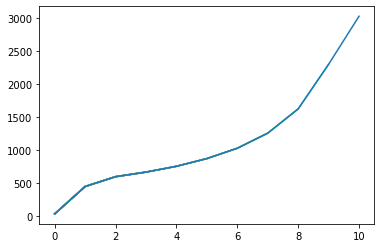

In [14]:
####################################
######## Run This Cell #########
####################################

import matplotlib

len1 = []
for r in reviews:
  len1.append(len(r)) 

len2 =[]

for i in [0,10,20,30,40,50,60,70,80,90,95]:
  len2.append(int(np.percentile(np.array(len1),i)))
  matplotlib.pyplot.plot(len2)

# Before 60th percentile, between 20th and 60th percentile, the rate of increase in length is a linear relationship
# After 60th percentile, the length of the reviews increase at an exponential rate
# Thus, it seems to be a natural cut-off, and we will use the 60th percentile as the max length for all the reviews,

max_review_len = int(np.percentile(np.array(len1),60))
print(max_review_len)

In [15]:
####################################
######## Run This Cell #########
####################################

# Make a batch to have sequence data for input and ouput
import nltk
nltk.download('punkt')
  
from nltk.tokenize import word_tokenize

def data_prep_sentiment(reviews,sentiments):
    x_train = []
    y_train = []
    count = -1
    for r in reviews:
      count+=1
      words = []
      if len(word_tokenize(r)) < max_review_len:
        for i in range(max_review_len - len(word_tokenize(r))):
            words.append(vocab_to_int["padword"]) 
        for w in word_tokenize(r):
            word = vocab_to_int[w]
            words.append(word)
      else:
        r_temp = word_tokenize(r)
        for i in range(max_review_len):
            word = vocab_to_int[r_temp[i]]
            words.append(word)
        
      x_train.append(words)
      y_train.append(sentiments[count])

    return x_train, y_train

# Preparing input
x_train, y_train = data_prep_sentiment(reviews_train,sentiments_train_int)
x_test, y_test = data_prep_sentiment(reviews_test,sentiments_test_int)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [210]:
print(trained_character_embeddings.shape)
print(trained_word_embeddings.shape)

(43055, 256)
(43055, 100)


In [0]:
####################################
######## Run This Cell #########
####################################

# create Tensor datasets
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 100

all_sequence_data = TensorDataset(torch.from_numpy(np.array(x_train)),torch.from_numpy(np.array(y_train)),torch.from_numpy(np.array(x_test)),torch.from_numpy(np.array(y_test))) 
all_sequence_loader = DataLoader(all_sequence_data, batch_size=batch_size, num_workers = 4, pin_memory=True)

### 2.3.2. Build Sequence Model

Here are justifications for the hyperparameter choices:
>
1. Total Number of Epoch = 25
  * Reason: Based on the trial and error, I found that optimal accuracy was achieved at after 20th epoch, but I would like to show that the model will overfit if we keep on training after epoch 20, so I set the total number of epoch to be 25.

2. Batch Size = 100
  * Reason: Based on trial and errors, this batch size is the sweet spot which gives a stable decrease in losses after each epoch, while it does not seem to be too slow to train, and finally this batch size will not cause the RAM and GPU memory usage to exceeds Colab's limit.
  
3. Learning Rate = 0.001
  * Reason: This is purely based on trial and errors.

4. Number of neuron in the LSTM = 128
  * Reason: Purely based on trial and errors, the GPU memory limits were also being considered there. If this parameter is too big, the GPU won't have enough memory to construct the model.

5. Probability of dropout = 0.05
  * Reason: Purely based on trial and errors, I have tried 0.2 before as well, but it would cause the model to under-fit.

Overall network architecture is very simple due to the memory constraints of the GPU and to save runtime. I believe a bigger or more complex model with higher maximum review length will probably lead to a higher F1 score, however, I ran out of time to test them.

In [0]:
####################################
######## Run This Cell #########
####################################

import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Please assign values to these variables by using other variables (instead of hard code)
n_input = trained_word_embeddings.shape[1] + trained_character_embeddings.shape[1]

#Please decide the hyperparameters here by yourself
n_hidden = 128
total_epoch = 20
learning_rate = 0.001
shown_interval = 1

class Sentiment_Model(nn.Module):
    def __init__(self):
        super(Sentiment_Model, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, num_layers=1, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden * 2,1)
        self.dropout = nn.Dropout(0.05)
        self.sigmoid = nn.Sigmoid() 
        

    def forward(self, x):
        x,_ = self.lstm(x)
        x = self.linear(x[:,-1,:])
        x = self.dropout(x) 
        x = self.sigmoid(x)
        return x

### 2.3.3. Train Sequence Model

In [19]:
from sklearn.metrics import f1_score

device = 'cuda'
Sentiment_Model = Sentiment_Model().to(device)
criterion = nn.BCELoss()

# Please find which optimizer provide higher f1
optimizer = optim.Adam(Sentiment_Model.parameters(), lr=learning_rate) 

f1_list_train = []
f1_list_test = []

for epoch in range(total_epoch):
    predictions_train = [] 
    predictions_test = []

    for batch_idx, (inputs, labels, inputs_test, labels_test) in enumerate(all_sequence_loader):      
      reviews_embeddings = []
      
      for r in inputs:
        inputs_embedding = []
        
        for w in r:
          trained_word_embedding = trained_word_embeddings[w].reshape(1,-1)
          trained_character_embedding = trained_character_embeddings[w].reshape(1,-1)
          inputs_embedding_temp = np.hstack((trained_word_embedding,trained_character_embedding))
          inputs_embedding.append(inputs_embedding_temp)
        
        reviews_embeddings.append(np.array(inputs_embedding).reshape(max_review_len,n_input))
      
      inputs_embeddings = torch.from_numpy(np.array(reviews_embeddings)).float() 
      inputs_torch = inputs_embeddings.to(device)
      labels_torch = labels.to(device)
    
      reviews_embeddings_test = []
      for r in inputs_test:
        inputs_embedding = []
        
        for w in r:
          trained_word_embedding = trained_word_embeddings[w].reshape(1,-1)
          trained_character_embedding = trained_character_embeddings[w].reshape(1,-1)
          inputs_embedding_temp = np.hstack((trained_word_embedding,trained_character_embedding))
          inputs_embedding.append(inputs_embedding_temp)
        
        reviews_embeddings_test.append(np.array(inputs_embedding).reshape(max_review_len,n_input))
      
      inputs_embeddings_test = torch.from_numpy(np.array(reviews_embeddings_test)).float() 
      inputs_torch_test = inputs_embeddings_test.to(device)
      labels_torch_test = labels_test.to(device)

      Sentiment_Model.eval()
      outputs_test = Sentiment_Model(inputs_torch_test).view(-1)
      loss_test = criterion(outputs_test, labels_torch_test.float())
      
      Sentiment_Model.train()
      optimizer.zero_grad()
      outputs = Sentiment_Model(inputs_torch).view(-1)
      loss = criterion(outputs, labels_torch.float())
      loss.backward()
      optimizer.step()

      Sentiment_Model.eval()
        
      outputs_train = Sentiment_Model(inputs_torch).view(-1) 
      train_loss = criterion(outputs_train, labels_torch.float())
      predicted_train = outputs_train.detach().cpu().numpy()
        
      for i in range(predicted_train.shape[0]):
        if predicted_train[i] > 0.5:
          predictions_train.append(1)
        else:
          predictions_train.append(0)

      outputs_test = Sentiment_Model(inputs_torch_test).view(-1) 
      test_loss = criterion(outputs_test, labels_torch_test.float())
      predicted_test = outputs_test.detach().cpu().numpy()
        
      for i in range(predicted_test.shape[0]):
        if predicted_test[i] > 0.5:
          predictions_test.append(1)
        else:
          predictions_test.append(0)

    if epoch % shown_interval == 0:
      train_F1= round(f1_score(np.array(predictions_train),np.array(y_train)),4)      
      test_F1= round(f1_score(np.array(predictions_test),np.array(y_test)),4)
      print('Epoch: %d, train loss: %.5f, train_F1: %.4f, test loss: %.5f, test_F1: %.4f'%(epoch + 1, train_loss.item(), train_F1, test_loss.item(), test_F1))

      f1_list_train.append(train_F1)
      f1_list_test.append(test_F1)

print('Finished Training')

Epoch: 1, train loss: 0.65479, train_F1: 0.6133, test loss: 0.62483, test_F1: 0.6136
Epoch: 2, train loss: 0.56883, train_F1: 0.6845, test loss: 0.53443, test_F1: 0.6856
Epoch: 3, train loss: 0.65964, train_F1: 0.6762, test loss: 0.64156, test_F1: 0.6777
Epoch: 4, train loss: 0.59021, train_F1: 0.6766, test loss: 0.60961, test_F1: 0.6757
Epoch: 5, train loss: 0.66596, train_F1: 0.6682, test loss: 0.67578, test_F1: 0.6605
Epoch: 6, train loss: 0.64229, train_F1: 0.6775, test loss: 0.65813, test_F1: 0.6665
Epoch: 7, train loss: 0.49066, train_F1: 0.7621, test loss: 0.49663, test_F1: 0.7534
Epoch: 8, train loss: 0.47378, train_F1: 0.8038, test loss: 0.42361, test_F1: 0.8008
Epoch: 9, train loss: 0.40060, train_F1: 0.8300, test loss: 0.37011, test_F1: 0.8237
Epoch: 10, train loss: 0.36552, train_F1: 0.8459, test loss: 0.32410, test_F1: 0.8397
Epoch: 11, train loss: 0.38846, train_F1: 0.8568, test loss: 0.33815, test_F1: 0.8479
Epoch: 12, train loss: 0.36043, train_F1: 0.8651, test loss: 0.

In [0]:
torch.save(Sentiment_Model.state_dict(), '/content/drive/My Drive/Sentiment_Model.pt')

In [24]:
# Train another 5 Epoch to check whether this model has converged

for epoch in range(20,25):
    predictions_train = [] 
    predictions_test = []

    for batch_idx, (inputs, labels, inputs_test, labels_test) in enumerate(all_sequence_loader):      
      reviews_embeddings = []
      
      for r in inputs:
        inputs_embedding = []
        
        for w in r:
          trained_word_embedding = trained_word_embeddings[w].reshape(1,-1)
          trained_character_embedding = trained_character_embeddings[w].reshape(1,-1)
          inputs_embedding_temp = np.hstack((trained_word_embedding,trained_character_embedding))
          inputs_embedding.append(inputs_embedding_temp)
        
        reviews_embeddings.append(np.array(inputs_embedding).reshape(max_review_len,n_input))
      
      inputs_embeddings = torch.from_numpy(np.array(reviews_embeddings)).float() 
      inputs_torch = inputs_embeddings.to(device)
      labels_torch = labels.to(device)
    
      reviews_embeddings_test = []
      for r in inputs_test:
        inputs_embedding = []
        
        for w in r:
          trained_word_embedding = trained_word_embeddings[w].reshape(1,-1)
          trained_character_embedding = trained_character_embeddings[w].reshape(1,-1)
          inputs_embedding_temp = np.hstack((trained_word_embedding,trained_character_embedding))
          inputs_embedding.append(inputs_embedding_temp)
        
        reviews_embeddings_test.append(np.array(inputs_embedding).reshape(max_review_len,n_input))
      
      inputs_embeddings_test = torch.from_numpy(np.array(reviews_embeddings_test)).float() 
      inputs_torch_test = inputs_embeddings_test.to(device)
      labels_torch_test = labels_test.to(device)

      Sentiment_Model.eval()
      outputs_test = Sentiment_Model(inputs_torch_test).view(-1)
      loss_test = criterion(outputs_test, labels_torch_test.float())
      
      Sentiment_Model.train()
      optimizer.zero_grad()
      outputs = Sentiment_Model(inputs_torch).view(-1)
      loss = criterion(outputs, labels_torch.float())
      loss.backward()
      optimizer.step()

      Sentiment_Model.eval()
        
      outputs_train = Sentiment_Model(inputs_torch).view(-1) 
      train_loss = criterion(outputs_train, labels_torch.float())
      predicted_train = outputs_train.detach().cpu().numpy()
        
      for i in range(predicted_train.shape[0]):
        if predicted_train[i] > 0.5:
          predictions_train.append(1)
        else:
          predictions_train.append(0)

      outputs_test = Sentiment_Model(inputs_torch_test).view(-1) 
      test_loss = criterion(outputs_test, labels_torch_test.float())
      predicted_test = outputs_test.detach().cpu().numpy()
        
      for i in range(predicted_test.shape[0]):
        if predicted_test[i] > 0.5:
          predictions_test.append(1)
        else:
          predictions_test.append(0)

    if epoch % shown_interval == 0:
      train_F1= round(f1_score(np.array(predictions_train),np.array(y_train)),4)      
      test_F1= round(f1_score(np.array(predictions_test),np.array(y_test)),4)
      print('Epoch: %d, train loss: %.5f, train_F1: %.4f, test loss: %.5f, test_F1: %.4f'%(epoch + 1, train_loss.item(), train_F1, test_loss.item(), test_F1))

      f1_list_train.append(train_F1)
      f1_list_test.append(test_F1)

print('Finished Training')


Epoch: 21, train loss: 0.31232, train_F1: 0.9046, test loss: 0.29601, test_F1: 0.8664
Epoch: 22, train loss: 0.31420, train_F1: 0.9096, test loss: 0.30772, test_F1: 0.8670
Epoch: 23, train loss: 0.30215, train_F1: 0.9151, test loss: 0.29472, test_F1: 0.8651
Epoch: 24, train loss: 0.28153, train_F1: 0.9161, test loss: 0.29577, test_F1: 0.8664
Epoch: 25, train loss: 0.27377, train_F1: 0.9208, test loss: 0.29607, test_F1: 0.8661
Finished Training


In [0]:
torch.save(Sentiment_Model.state_dict(), '/content/drive/My Drive/Sentiment_Model - Overfit.pt')

### 2.3.4. Save Sequence Model
(*This step has been done as part of training, please refer to the previous session for details*)

### 2.3.5. Load Sequence Model

In [37]:
####################################
######## Run This Cell #########
####################################
id = '18v8UNfPpcwkn_tzPeuAcfGHmymD0pjVv'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Sentiment_Model.pt')

Sentiment_Model_load = Sentiment_Model().to('cuda')
Sentiment_Model_load.load_state_dict(torch.load('Sentiment_Model.pt'))

<All keys matched successfully>

# 3 - Evaluation

(*Please show your empirical evidence*)

## 3.1. Performance Evaluation


You are required to provide the table with precision, recall, f1 of test set.

In [0]:
####################################
######## Run This Cell #########
####################################

device = 'cuda'
for epoch in range(1):
    predictions_test = []

    for batch_idx, (inputs, labels, inputs_test, labels_test) in enumerate(all_sequence_loader):      

      reviews_embeddings_test = []
      for r in inputs_test:
        inputs_embedding = []
        
        for w in r:
          trained_word_embedding = trained_word_embeddings[w].reshape(1,-1)
          trained_character_embedding = trained_character_embeddings[w].reshape(1,-1)
          inputs_embedding_temp = np.hstack((trained_word_embedding,trained_character_embedding))
          inputs_embedding.append(inputs_embedding_temp)
        
        reviews_embeddings_test.append(np.array(inputs_embedding).reshape(max_review_len,n_input))
      
      inputs_embeddings_test = torch.from_numpy(np.array(reviews_embeddings_test)).float() 
      inputs_torch_test = inputs_embeddings_test.to(device)
      labels_torch_test = labels_test.to(device)

      Sentiment_Model_load.eval()
        
      outputs_test = Sentiment_Model_load(inputs_torch_test).view(-1) 
      predicted_test = outputs_test.detach().cpu().numpy()
        
      for i in range(predicted_test.shape[0]):
        if predicted_test[i] > 0.5:
          predictions_test.append(1)
        else:
          predictions_test.append(0)

In [39]:
####################################
######## Run This Cell #########
####################################

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_test,digits=4))

              precision    recall  f1-score   support

           0     0.8644    0.8774    0.8708     12500
           1     0.8755    0.8623    0.8689     12500

    accuracy                         0.8698     25000
   macro avg     0.8699    0.8698    0.8698     25000
weighted avg     0.8699    0.8698    0.8698     25000



## 3.2. Hyperparameter Testing
Based on the graph below, the F1 score on test dataset started to converged and even decreased slightly after the 20th epoch, while the F1 score on training dataset continues to increase. That is a sign of over-fitting. Thus, the optimal number of epoch for the given hyper-parameters should be 20.

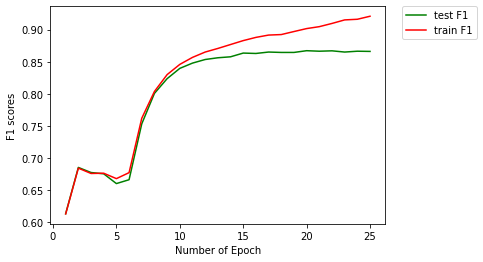

In [48]:
import matplotlib as matplot
epoch_num = np.array(range(1,26))
matplot.pyplot.plot(epoch_num,np.array(f1_list_test),color="green",label="test F1")
matplot.pyplot.plot(epoch_num,np.array(f1_list_train),color="red",label="train F1")
matplot.pyplot.xlabel("Number of Epoch")
matplot.pyplot.ylabel("F1 scores")
matplot.pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

matplot.pyplot.show()